In [1]:
using Pkg
cd("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\")
Pkg.activate(".");

In [2]:
using Statistics, Printf
using Oceananigans, Oceananigans.Operators

In [ ]:
@inline incmod1(a, n) = a == n ? one(a) : a + 1
@inline decmod1(a, n) = a == 1 ? n : a - 1

function laplacian3d_ppn(f)
    Nx, Ny, Nz = size(f)
    ∇²f = zeros(Nx, Ny, Nz)
    for k in 2:(Nz-1), j in 1:Ny, i in 1:Nx
       ∇²f[i, j, k] = f[incmod1(i, Nx), j, k] + f[decmod1(i, Nx), j, k] + f[i, incmod1(j, Ny), k] + f[i, decmod1(j, Ny), k] + f[i, j, k+1] + f[i, j, k-1] - 6*f[i, j, k]
    end
    for j in 1:Ny, i in 1:Nx
        ∇²f[i, j,   1] = -(f[i, j,     1] - f[i, j,   2]) + f[incmod1(i, Nx), j,   1] + f[decmod1(i, Nx), j,   1] + f[i, incmod1(j, Ny),   1] + f[i, decmod1(j, Ny),   1] - 4*f[i, j,   1]
        ∇²f[i, j, end] =  (f[i, j, end-1] - f[i, j, end]) + f[incmod1(i, Nx), j, end] + f[decmod1(i, Nx), j, end] + f[i, incmod1(j, Ny), end] + f[i, decmod1(j, Ny), end] - 4*f[i, j, end]
    end
    ∇²f
end

In [ ]:
Nx, Ny, Nz = 10, 1, 10
f = rand(Nx, Ny, Nz)
f .= f .- mean(f)
ϕ = solve_poisson_3d_ppn(f, Nx, Ny, Nz, 1, 1, 1)
laplacian3d_ppn(ϕ) ≈ f

In [ ]:
# g =  RegularCartesianGrid((10, 1, 10), (2000, 2000, 1000), Float64)

In [3]:
include("src/operators/operators_old.jl")
include("src/equation_of_state.jl")

ρ (generic function with 1 method)

In [ ]:
A3 = rand(10, 10, 10);
A2 = A3[:, 1:1, :];

In [ ]:
slice = δˣf2c(A3)[:, 1:1, :]; @show slice == δˣf2c(A2);
slice = δˣc2f(A3)[:, 1:1, :]; @show slice == δˣc2f(A2);
slice = δʸf2c(A3)[:, 1:1, :]; @show slice == δʸf2c(A2);  # Should be zero. zeros(Nx, Ny, Nz)
slice = δʸc2f(A3)[:, 1:1, :]; @show slice == δʸc2f(A2);  # Should be zero. zeros(Nx, Ny, Nz)
slice = δᶻf2c(A3)[:, 1:1, :]; @show slice == δᶻf2c(A2);
slice = δᶻc2f(A3)[:, 1:1, :]; @show slice == δᶻc2f(A2);

In [ ]:
slice = avgˣf2c(A3)[:, 1:1, :]; @show slice == avgˣf2c(A2);
slice = avgˣc2f(A3)[:, 1:1, :]; @show slice == avgˣc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show slice == avgʸc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show slice == avgʸc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show avgʸf2c(A2) == A2;
slice = avgʸc2f(A3)[:, 1:1, :]; @show avgʸc2f(A2) == A2;
slice = avgᶻf2c(A3)[:, 1:1, :]; @show slice == avgᶻf2c(A2);
slice = avgᶻc2f(A3)[:, 1:1, :]; @show slice == avgᶻc2f(A2);

In [19]:
const NumType = Float64  # Number data type.
const g = 9.80665  # Standard acceleration due to gravity [m/s²].
const χ = 0.1  # Adams-Bashforth (AB2) parameter.

Nˣ, Nʸ, Nᶻ = 100, 1, 100
Lˣ, Lʸ, Lᶻ = 2000, 2000, 2000  # Domain size [m].

Nᵗ = 18000
Δt = 5  # Time step [s].

Δx, Δy, Δz = Lˣ/Nˣ, Lʸ/Nʸ, Lᶻ/Nᶻ  # Grid spacing [m].
Aˣ, Aʸ, Aᶻ = Δy*Δz, Δx*Δz, Δx*Δy  # Cell face areas [m²].
V = Δx*Δy*Δz  # Volume of a cell [m³].
M = ρ₀*V  # Mass of water in a cell [kg].

xC = Δx/2:Δx:Lˣ
yC = Δy/2:Δy:Lʸ
zC = -Δz/2:-Δz:-Lᶻ

uⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in x-direction [m/s].
vⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in y-direction [m/s].
wⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in z-direction [m/s].
Tⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Potential temperature [K].
Sⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Salinity [g/kg].
pʰʸ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ) # Hydrostatic pressure [Pa].
pⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Pressure [Pa].
ρⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Density [kg/m³].

Gᵘⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

pʰʸ′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
pⁿʰ⁺ˢ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
g′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
δρ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ);

In [20]:
uⁿ .= 0; vⁿ .= 0; wⁿ .= 0; Sⁿ .= 35;

# Tⁿ = repeat(reshape(T_ref, 1, 1, 50), Nˣ, Nʸ, 1)
Tⁿ .= 283

pHY_profile = [-ρ₀*g*h for h in zC]
pʰʸ = repeat(reshape(pHY_profile, 1, 1, Nᶻ), Nˣ, Nʸ, 1)
pⁿ = copy(pʰʸ)  # Initial pressure is just the hydrostatic pressure.

ρⁿ .= ρ.(Tⁿ, Sⁿ, pⁿ);

Tⁿ[Int(Nˣ/2)-2:Int(Nˣ/2)+2, 1, 10-2:10+2] .= 283.1;

In [21]:
# # PyPlot.pcolormesh( 0.2 * exp.(10*((xC .- Lˣ/2).^2 .+ (zC .+ Lᶻ/2)'.^2).^(-0.5)) ) ; PyPlot.colorbar();
# ΔT = 0.05 * exp.(10*((xC .- Lˣ/2).^2 .+ (zC .+ Lᶻ/2)'.^2).^(-0.5))
# ΔT = reshape(ΔT, (100, 1, 100))
# Tⁿ .= Tⁿ .+ ΔT;
# PyPlot.pcolormesh(Tⁿ[:, 1, :] .- 283) ; PyPlot.colorbar();

In [22]:
ΔR = 10
Ru = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# Rv = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rw = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
RT = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RS = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rρ = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RpHY′ = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
RpNHS = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ);

In [23]:
κʰ = 4e-2  # Horizontal Laplacian heat diffusion [m²/s]. diffKhT in MITgcm.
κᵛ = 4e-2  # Vertical Laplacian heat diffusion [m²/s]. diffKzT in MITgcm.

0.04

In [24]:
function time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)
    for n in 1:Nᵗ
        # Calculate new density and density deviation.
        @. δρ = ρ(Tⁿ, Sⁿ, pⁿ) - ρ₀
        @. ρⁿ = ρ₀ + δρ
        
        δρ̅ᶻ = avgᶻc2f(δρ)
        for j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, 1] = δρ[i, j, 1] * g * Δz / 2
        end
        for k in 2:Nᶻ, j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, k] = pʰʸ′[i, j, k-1] + (δρ̅ᶻ[i, j, k] * g * Δz)
        end
        
        Gᵘⁿ⁻¹ = Gᵘⁿ; Gᵛⁿ⁻¹ = Gᵛⁿ; Gʷⁿ⁻¹ = Gʷⁿ; Gᵀⁿ⁻¹ = Gᵀⁿ; Gˢⁿ⁻¹ = Gˢⁿ;

        Gᵘⁿ .= -(1/Δx) .* δˣc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²u(uⁿ)
        Gᵛⁿ .= -(1/Δy) .* δʸc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²v(vⁿ)
        Gʷⁿ .= 𝜈ᵛ∇²w(wⁿ)
        Gᵀⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Tⁿ) .+ κ∇²(Tⁿ)
        Gˢⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Sⁿ) .+ κ∇²(Sⁿ)
        
        @. begin
            Gᵘⁿ⁺ʰ = (3/2 + χ)*Gᵘⁿ - (1/2 + χ)*Gᵘⁿ⁻¹
            Gᵛⁿ⁺ʰ = (3/2 + χ)*Gᵛⁿ - (1/2 + χ)*Gᵛⁿ⁻¹
            Gʷⁿ⁺ʰ = (3/2 + χ)*Gʷⁿ - (1/2 + χ)*Gʷⁿ⁻¹
            Gᵀⁿ⁺ʰ = (3/2 + χ)*Gᵀⁿ - (1/2 + χ)*Gᵀⁿ⁻¹
            Gˢⁿ⁺ʰ = (3/2 + χ)*Gˢⁿ - (1/2 + χ)*Gˢⁿ⁻¹
        end
        
        RHS = div_f2c(Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ)  # Right hand side or source term.
        pⁿʰ⁺ˢ = solve_poisson_3d_ppn(RHS, Nˣ, Nʸ, Nᶻ, Δx, Δy, Δz)
        
#         RHS_rec = laplacian3d_ppn(pⁿʰ⁺ˢ) ./ (Δx)^2  # TODO: This assumes Δx == Δy == Δz.
#         error = RHS_rec .- RHS
#         @info begin
#             string("Fourier-spectral solver diagnostics:\n",
#                     @sprintf("RHS:     min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS), maximum(RHS), mean(RHS), mean(abs.(RHS)), std(RHS)),
#                     @sprintf("RHS_rec: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS_rec), maximum(RHS_rec), mean(RHS_rec), mean(abs.(RHS_rec)), std(RHS_rec)),
#                     @sprintf("error:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(error), maximum(error), mean(error), mean(abs.(error)), std(error))
#                     )
#         end
        
        @. pⁿ = pʰʸ′ + pⁿʰ⁺ˢ

        uⁿ .= uⁿ .+ ( Gᵘⁿ⁺ʰ .- (1/Δx) .* δˣc2f(pⁿʰ⁺ˢ) ) .* Δt
        vⁿ .= vⁿ .+ ( Gᵛⁿ⁺ʰ .- (1/Δy) .* δʸc2f(pⁿʰ⁺ˢ) ) .* Δt
        wⁿ .= wⁿ .+ ( Gʷⁿ⁺ʰ .- (1/Δz) .* δᶻc2f(pⁿʰ⁺ˢ) ) .* Δt

        @. Sⁿ = Sⁿ + (Gˢⁿ⁺ʰ * Δt)
        @. Tⁿ = Tⁿ + (Gᵀⁿ⁺ʰ * Δt)
        
        div_u1 = div_f2c(uⁿ, vⁿ, wⁿ)
        
        if n % ΔR == 0
            print("\rt=$(n*Δt)/$(Nᵗ*Δt)")
#             @info begin
#             string("Time: $(n*Δt)\n",
#                    @sprintf("uⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(uⁿ), maximum(uⁿ), mean(uⁿ), mean(abs.(uⁿ)), std(uⁿ)),
#                    @sprintf("vⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(vⁿ), maximum(vⁿ), mean(vⁿ), mean(abs.(vⁿ)), std(vⁿ)),
#                    @sprintf("wⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(wⁿ), maximum(wⁿ), mean(wⁿ), mean(abs.(wⁿ)), std(wⁿ)),
#                    @sprintf("Tⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Tⁿ), maximum(Tⁿ), mean(Tⁿ), mean(abs.(Tⁿ)), std(Tⁿ)),
#                    @sprintf("Sⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Sⁿ), maximum(Sⁿ), mean(Sⁿ), mean(abs.(Sⁿ)), std(Sⁿ)),
#                    @sprintf("pʰʸ:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ), maximum(pʰʸ), mean(pʰʸ), mean(abs.(pʰʸ)), std(pʰʸ)),
#                    @sprintf("pʰʸ′: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ′), maximum(pʰʸ′), mean(pʰʸ′), mean(abs.(pʰʸ′)), std(pʰʸ′)),
#                    @sprintf("pⁿʰ⁺ˢ:min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿʰ⁺ˢ), maximum(pⁿʰ⁺ˢ), mean(pⁿʰ⁺ˢ), mean(abs.(pⁿʰ⁺ˢ)), std(pⁿʰ⁺ˢ)),
#                    @sprintf("pⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿ), maximum(pⁿ), mean(pⁿ), mean(abs.(pⁿ)), std(pⁿ)),
#                    @sprintf("ρⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(ρⁿ), maximum(ρⁿ), mean(ρⁿ), mean(abs.(ρⁿ)), std(ρⁿ)),
#                    @sprintf("δρ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(δρ), maximum(δρ), mean(δρ), mean(abs.(δρ)), std(δρ)),
#                    @sprintf("∇⋅u1:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(div_u1), maximum(div_u1), mean(div_u1), mean(abs.(div_u1)), std(div_u1))
#                   )
#             end  # @info

            Ridx = Int(n/ΔR)
            Ru[Ridx, :, :, :] = copy(uⁿ)
            # Rv[n, :, :, :] = copy(vⁿ)
            Rw[Ridx, :, :, :] = copy(wⁿ)
            RT[Ridx, :, :, :] = copy(Tⁿ)
            # RS[n, :, :, :] = copy(Sⁿ)
            Rρ[Ridx, :, :, :] = copy(ρⁿ)
            # RpHY′[n, :, :, :] = copy(pʰʸ′)
            RpNHS[Ridx, :, :, :] = copy(pⁿʰ⁺ˢ)
        end
    end
end

time_stepping (generic function with 1 method)

In [25]:
@time time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)

t=90000/90000179.021305 seconds (2.00 G allocations: 216.350 GiB, 13.44% gc time)


In [11]:
import PyPlot
using Interact, Plots
Plots.gr()

HTML{String}("    <script id=\"webio-setup-11593438337325196983\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-5718778909116300137\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-11593438337325196983\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-5718778909116300137\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

┌ Info: Recompiling stale cache file C:\Users\Ali\.julia\compiled\v1.0\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


Plots.GRBackend()

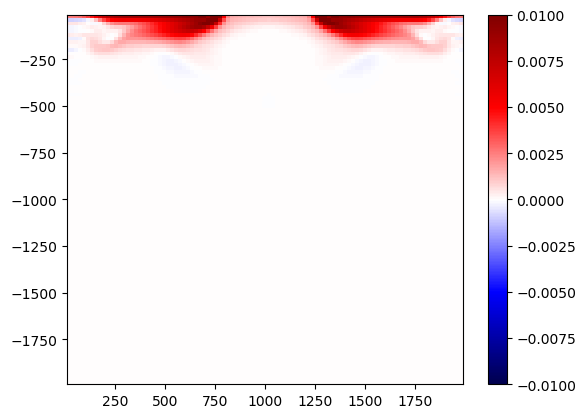

In [35]:
PyPlot.pcolormesh(xC, zC, rotr90(RT[1200, :, 1, :]) .- 283, vmin=-0.01, vmax=0.01, cmap="seismic"); PyPlot.colorbar();

In [33]:
anim = @animate for tidx in 1:Int(Nᵗ/ΔR)
    Plots.heatmap(xC, zC, rotl90(RT[tidx, :, 1, :]) .- 283, color=:balance,
        clims=(-maximum(RT[tidx, :, 1, :] .- 283), maximum(RT[tidx, :, 1, :] .- 283)),
        title="T change @ t=$(tidx*ΔR*Δt)")
end
mp4(anim, "tracer.mp4", fps = 60)

┌ Info: Saved animation to 
│   fn = C:\Users\Ali\Documents\Git\Oceananigans.jl\tracer.mp4
└ @ Plots C:\Users\Ali\.julia\packages\Plots\y6yik\src\animation.jl:90


Plots.AnimatedGif("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\tracer.mp4")

In [ ]:
Plots.heatmap(xC, zC, rotl90(RT[end, :, 1, :]) .- 283, clims=(-0.1, 0.1), color=:balance)

In [ ]:
matshow(RT[end, :, 1, :])

In [ ]:
sum(RT[10, :, 1, :] .- 283)